In [106]:
! which python3
! python3 -V

/home/mykmur/dev/venv/bin/python3
Python 3.8.15


In [107]:
import typing as t
import jraph
import jax.numpy as jnp
import metadata
import haiku as hk
import utils
import jax
import optax
import functools as ft

In [108]:
WINDOW = int(31*12*24*60/5)
VIS = False

In [109]:
def create_graph_tuple(senders, receivers, edges) -> jraph.GraphsTuple:
    return jraph.GraphsTuple(
        nodes=None,
        edges=edges,
        senders=senders,
        receivers=receivers,
        n_node=jnp.asarray([metadata.NUM_NODES]),
        n_edge=jnp.asarray([metadata.NUM_EDGES]),
        globals=None)

In [110]:
_senders = []
_receivers = []

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
nodes = jnp.array([1] * metadata.NUM_NODES)
edges = jnp.array([1] * metadata.NUM_EDGES)

graph_features = jnp.array([[1]])
graph = create_graph_tuple(senders, receivers, edges)

if VIS:
    utils.draw_jraph_graph_structure(graph)

In [111]:
@jax.jit
def to_bytes(arr):
  """ Converts an array of uint32 into an array of bytes in little endian"""

  @ft.partial(jax.vmap, in_axes=(None,0))
  def _to_bytes(arr, byte_index:int):
    mask = 0xFF << (8 * byte_index)
    b = (arr & mask) >> 8 * byte_index
    return  b.astype(jnp.uint8)

  return _to_bytes(arr, jnp.arange(4))

@ft.partial(jax.jit,static_argnames=("axis"))
def from_bytes(array,axis):
  """ Converts an array of bytes in little endian  into an array of uint32"""
  @ft.partial(jax.vmap,in_axes=(axis,0))
  def _from_bytes(arr,byte_index):
    return arr<<8*byte_index

  return jnp.sum(_from_bytes(array,jnp.arange(4)),axis=axis)


In [112]:
to_bytes(jnp.array([257]))

Array([[1],
       [1],
       [0],
       [0]], dtype=uint8)

In [113]:
from_bytes(jnp.array([0, 1, 0, 0]), axis=0)

Array(256, dtype=int32)

### Load data

In [114]:
import pandas as pd

In [115]:
df = pd.read_pickle("../data/samples_5m_subset_v1.pkl")

In [116]:
def get_data_for_link(src: str, dst: str) -> jnp.array:
    ss: pd.Series = df[(df["src_host"] == src) & (df["dst_host"] == dst)]
    return ss.incoming_rate_avg.to_numpy()

In [117]:
_map = metadata.NODE_IDS_TO_LABELS_MAPPING

_senders = []
_receivers = []
_edges = jnp.array([[]])

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _edges = jnp.append(_edges,
                get_data_for_link(_map[x], _map[y]))
                
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
edges = jnp.array(_edges.reshape((metadata.NUM_EDGES, int(len(_edges)/metadata.NUM_EDGES))), dtype=jnp.uint32)

In [118]:
graph = create_graph_tuple(senders, receivers, edges)

In [119]:
if VIS:
    utils.draw_jraph_graph_structure(graph)

### Model

In [120]:
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-2
SPLIT = 0.9
BLOCK_SIZE = int(24*60/5)  # 1 day
BATCH_SIZE = 8
SEED = 2137
NUM_TRAINING_STEPS = 600
EVAL_INTERVAL = 10

In [121]:
n = int(SPLIT * edges.shape[1])
d_train = edges[0][:n]
d_val = edges[0][n:]

In [122]:
d_train.dtype

dtype('uint32')

In [123]:
d_train_emb = to_bytes(d_train).T
d_val_emb = to_bytes(d_val).T

d_train_emb.shape, d_val_emb.shape

((146043, 4), (16227, 4))

In [124]:
d_train = jnp.log(d_train)
d_val = jnp.log(d_val)

In [125]:
d_val.shape, d_train.shape, edges.shape

((16227,), (146043,), (15, 162270))

In [126]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class LoopValues(t.NamedTuple):
    tokens: jnp.ndarray
    state: t.Any
    rng_key: jnp.ndarray

Batch = t.Mapping[str, jnp.ndarray]

In [127]:
the_seed = hk.PRNGSequence(SEED)

def get_batch(split: str, emb = False) -> Batch:
    if emb:
        data = d_train_emb if split == "train" else d_val_emb
    else:
        data = d_train if split == "train" else d_val

    ixs = jax.random.randint(next(the_seed), (BATCH_SIZE, ), 0, len(data) - BLOCK_SIZE)

    x = jnp.stack([data[i:i+BLOCK_SIZE] for i in ixs], dtype=jnp.float32)
    y = jnp.stack([data[i+1:i+BLOCK_SIZE+1] for i in ixs], dtype=jnp.float32)
    return {'input': x, 'target': y}

In [128]:
expl_batch = get_batch("train", True)

In [129]:
expl_batch['input'].shape

(8, 288, 4)

In [130]:
_off = 30
plot = utils.plot_samples(
    truth=expl_batch['target'][0, :_off],
    prediction=expl_batch['input'][0, :_off],
    truth_label='y, target',
    prediction_label='x, input')
plot.draw()

ValueError: If using all scalar values, you must pass an index

In [131]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    model = hk.GRU(HIDDEN_SIZE)
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

In [171]:
def sequence_loss(batch: Batch) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    batch_size, sequence_length, _ = batch['input'].shape  # (B, T, F)

    initial_state = core.initial_state(batch_size)

    # _input = jnp.expand_dims(batch['input'], -1)  # (B, T, 1)
    _input = batch['input']
    # print(_input.shape)

    logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)  # (B, T, HIDDEN_SIZE)
    # print(logits.shape)

    logits_batched = hk.BatchApply(hk.Linear(4))(logits)  # (B, T, 4)
    # print(logits_batched.shape)
    # print(batch['target'].shape)
    # dcd_target = from_bytes(jnp.array(expl_batch['target'], dtype=jnp.uint32).T, axis=0)
    # dcd_target = from_bytes(jnp.array(expl_batch['target'], dtype=jnp.uint32).T, axis=0)

    loss = jnp.mean(jnp.square(batch['target'] - logits_batched))  # MAE
    return loss

In [172]:
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state)

In [173]:
expl_batch['target'].shape

(8, 288, 4)

In [174]:
from_bytes(jnp.array(expl_batch['target'], dtype=jnp.uint32).T, axis=0).shape

(288, 8)

In [175]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
initial_params = init_params_fn(next(rng), expl_batch)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state)

In [176]:
loss_fn = jax.jit(loss_fn)

In [177]:
train_loss_all = jnp.array([])
eval_loss_all = jnp.array([])

for step in range(NUM_TRAINING_STEPS):
    train_batch = get_batch("train", True)
    state = update(state, train_batch)

    if step % EVAL_INTERVAL == 0:
        eval_batch = get_batch("eval", True)
        train_loss = loss_fn(state.params, train_batch)
        eval_loss = loss_fn(state.params, eval_batch)
        train_loss_all = jnp.append(train_loss_all, train_loss)
        eval_loss_all = jnp.append(eval_loss_all, eval_loss)
        print({
            'step': step,
            'train_loss': float(train_loss),
            'eval_loss': float(eval_loss),
        })

final_state = state

{'step': 0, 'train_loss': 15733.4169921875, 'eval_loss': 15386.1357421875}
{'step': 10, 'train_loss': 11911.796875, 'eval_loss': 12143.193359375}
{'step': 20, 'train_loss': 8668.3896484375, 'eval_loss': 8642.7392578125}
{'step': 30, 'train_loss': 6226.814453125, 'eval_loss': 6421.62890625}
{'step': 40, 'train_loss': 5100.8974609375, 'eval_loss': 4963.71728515625}
{'step': 50, 'train_loss': 4203.34375, 'eval_loss': 4306.2333984375}
{'step': 60, 'train_loss': 3968.046142578125, 'eval_loss': 3971.805908203125}
{'step': 70, 'train_loss': 3941.452392578125, 'eval_loss': 3786.587646484375}
{'step': 80, 'train_loss': 4020.843017578125, 'eval_loss': 3972.061767578125}
{'step': 90, 'train_loss': 3936.454833984375, 'eval_loss': 3834.0087890625}
{'step': 100, 'train_loss': 3872.682373046875, 'eval_loss': 3884.456298828125}
{'step': 110, 'train_loss': 3956.9814453125, 'eval_loss': 3925.557373046875}
{'step': 120, 'train_loss': 3967.9853515625, 'eval_loss': 3790.15185546875}
{'step': 130, 'train_lo

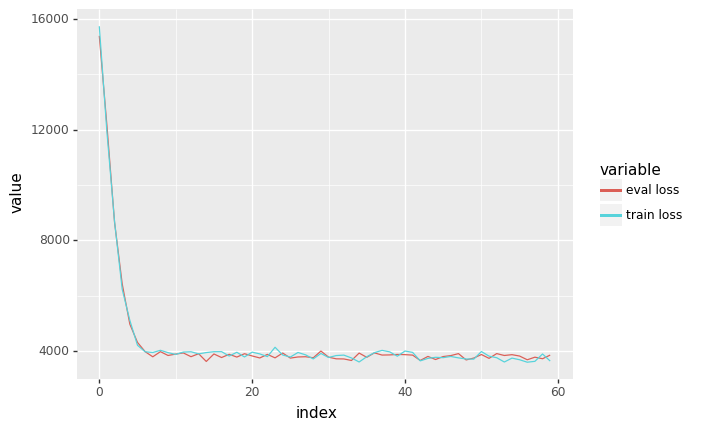

In [178]:
plot = utils.plot_samples(
    truth=train_loss_all, 
    prediction=eval_loss_all,
    truth_label='train loss',
    prediction_label='eval loss')
plot.draw()

### Generating data from the model

In [179]:
def generate(context: jnp.ndarray, seq_len: int) -> jnp.array:
    """Draws samples from the model, given an initial context."""
    core = make_network()
    dense = hk.Linear(4)

    batch_size, sequence_length, feat = context.shape  # (B, T, F)

    print(context.shape)

    initial_state = core.initial_state(batch_size)

    # _input = jnp.expand_dims(context, -1)  # (B, T, 1)
    _input = jnp.reshape(context, (BLOCK_SIZE, 1, feat))

    context_outs, state = hk.dynamic_unroll(core, _input, initial_state)
    context_outs = hk.BatchApply(dense)(context_outs)

    print(f" Ctx: {context_outs.shape}")
    # Now, unroll one step at a time using the running recurrent state.
    _outs = []
    logits = context_outs[-1, -1]
    print(logits.shape)
    for _ in range(seq_len - sequence_length):
        logits, state = core(logits, state)
        logits = dense(logits)
        _outs.append(logits)

    return jnp.concatenate([context_outs, jnp.stack(_outs)])

In [180]:
fast_ar_predict = hk.transform(generate)
fast_ar_predict = jax.jit(fast_ar_predict.apply, static_argnums=3)

In [181]:
val_batch = get_batch("valid", True)  # (B, T, F)
context = val_batch["input"][:1, :, :]
print(context.shape)
predicted = fast_ar_predict(final_state.params, None, context, 600)

(1, 288, 4)
(1, 288, 4)
 Ctx: (288, 1, 4)
(4,)


In [182]:
context.shape, predicted.shape, val_batch["target"].shape

((1, 288, 4), (600, 1, 4), (8, 288, 4))

In [183]:
predicted[0, 0, :], context[0, 0, :], val_batch["target"][0, 0, :]

(Array([114.23323   , 116.077324  , 117.9041    ,   0.27571738], dtype=float32),
 Array([240., 214.,  20.,   4.], dtype=float32),
 Array([ 88., 245.,  27.,   4.], dtype=float32))

In [184]:
dcd_context = from_bytes(jnp.array(context[0, :, :], dtype=jnp.uint32).T, axis=0)
dcd_target = from_bytes(jnp.array(val_batch["target"][0, :, :], dtype=jnp.uint32).T, axis=0)
dcd_preds = from_bytes(jnp.array(predicted[:, 0, :], dtype=jnp.uint32).T, axis=0)

In [185]:
print(f" MAE: {jnp.mean(jnp.abs(dcd_target - dcd_preds[:BLOCK_SIZE])):.4f}")
print(f" MSE: {jnp.mean(jnp.square(dcd_target - dcd_preds[:BLOCK_SIZE])):.4f}")

 MAE: 26224134.0000
 MSE: 22153690.0000


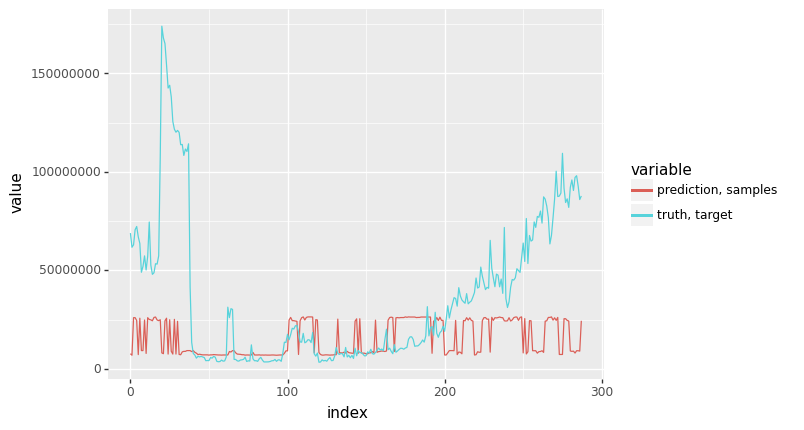

In [186]:
plot = utils.plot_samples(
    dcd_target,
    dcd_preds[:BLOCK_SIZE],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()